# A Neural Network from Scratch
This notebook will work through a couple of examples that build a neural network from scratch. It introduces the concepts of "perceptron", "activation function", "feedforward", and "backpropagation". The material is taken mostly from:

* [Basic Python Network](https://iamtrask.github.io/2015/07/12/basic-python-network/)

For a similar homemade neural network applied to the Semeion Datset of handwrittend digits, see

* [DIY AI: An old school matrix NN](https://towardsdatascience.com/diy-ai-an-old-school-matrix-nn-401a00021a55)

**Contents**

* <a href='#the_problem'>The Problem</a>
* <a href='#activation_function'>Activation Function</a>
* <a href='#neural_network'>The Neural Network</a>
* <a href='#breakdown'>Breaking it Down</a>
    * <a href='#feed_forward'>Feed Forward</a>
    * <a href='#error_convergence'>Error Convergence</a>
    * <a href='#err_wt_deriv'>Error Weighted Derivative</a>
    * <a href='#back_propagation'>Training: Back Propagation</a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt

<a id='the_problem'></a>
## The problem
We will use the simple table below to train the model. There are three features (columns), each with four samples (rows) that will be used to predict the state of the output at each sample.


 A | B | C | Output
---|---|---|---
 0 | 0 | 1 | 0
 1 | 1 | 1 | 1
 1 | 0 | 1 | 1
 0 | 1 | 1 | 0

<a id='activation_function'></a>
## Activation Function
The sigmoid, or logistic function is the decision making function. Its derivative is used to nudge predictions toward a yes (`1`) or no (`0`) result.

In [2]:
# sigmoid function
def nonlin(x,deriv=False):
    '''
    Nonlinear activation function.
    
    Params
    ------
    x : float
        Locations at which to calculate the activation function
    deriv : bool
        If True, caluclate the derivative of x, where x = nonlin(xx)
    
    Returns
    -------
    result : float
        Function value at points `x`
    '''
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

In [3]:
def nonlin_deriv(x):
    '''
    Derivative of the nonlinear activation function.
    
    Params
    ------
    x : float
        Locations at which to calculate the derivative of the activation function
    
    Returns
    -------
    result : float
        Function value at points `x`
    '''
    return nonlin(x)*(1-nonlin(x))

Plot the activation function and its derivative:

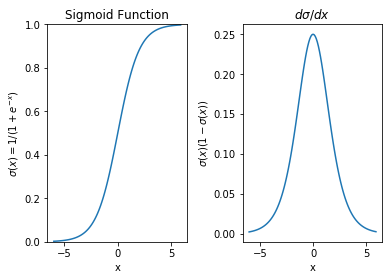

In [4]:
# Function values
x_sigmoid = np.arange(-6, 6, 0.1)
y_sigmoid = nonlin(x_sigmoid)
y_deriv = nonlin_deriv(x_sigmoid)

# Create the figure
fig, axes = plt.subplots(nrows=1, ncols=2)

# Plot the sigmoid function
axes[0].plot(x_sigmoid, y_sigmoid)
axes[0].set_title('Sigmoid Function')
axes[0].set_xlabel('x')
axes[0].set_ylabel('$\sigma(x) = 1/(1+e^{-x})$')
axes[0].set_ylim((0,1))

# Plot its derivative
axes[1].plot(x_sigmoid, y_deriv)
axes[1].set_title('$d\sigma/dx$')
axes[1].set_xlabel('x')
axes[1].set_ylabel('$\sigma(x) (1-\sigma(x))$')

# Adjust spacing between plots
plt.subplots_adjust(wspace=0.4)

<a id='neural_network'></a>
## The Neural Network
Create and run the neural network. It consists of an input layer, `l0`, one hidden layer, `l1`, and the output layer, `y`. The synapse, `s0` are a set of weights that connect the input layer to the hidden layer.

In [5]:
def neural_net(x, y, niter=10000):
    '''
    A simple perceptron neural network.
    
    Prameters
    ---------
    x : `np.ndarray`
        Input data, each feature represented as a column.
    y : `np.ndarray`
        Output to predict
    niter : int
        Number of iterations to perform
    
    Returns
    -------
    prediction : `np.ndarray`
        Predicted output
    '''
    # First layer of synapses connecting the input
    # layer to the output layer. Initialize weights
    # randomly with mean 0
    syn0 = 2*np.random.random((3,1)) - 1

    # Iterate
    for iter in range(niter):
        idx = iter // 10

        # Forward propagation
        l0 = x
        l1 = nonlin(np.dot(l0, syn0))

        # How much did we miss?
        l1_error = y - l1

        # Multiply how much we missed by the 
        # slope of the sigmoid at the values in l1
        l1_delta = l1_error * nonlin(l1, True)

        # Back propagation to update weights
        syn0 += np.dot(l0.T, l1_delta)

    return l1

Train the neural net on the data.

In [6]:
# Input dataset
x = np.array([[0,0,1],
              [1,1,1],
              [1,0,1],
              [0,1,1]])
    
# Output dataset            
y = np.array([[0,1,1,0]]).T

# Seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# Run the neural network
niter = 10000
prediction = neural_net(x, y, niter)

# Show the results
print('{0:>6s} {1:>12s}'.format('Output', 'Prediction'))
for output, predict in zip(y, prediction):
    print('{0:6d} {1:12.4f}'.format(output[0], predict[0]))

Output   Prediction
     0       0.0097
     1       0.9921
     1       0.9936
     0       0.0079


<a id='breakdown'></a>
## Breaking it Down
Here, we implement the `neural_net` function as a script and keep track various quantities of interest to see how they evolve with each iteration. The diagnostic quantities are:

In [7]:
# Diagnosics for demonstration
nstep = 10  # save results every nsteps
npts = niter // nstep  # number of points to save

# Parameters of the neural network
weighted_sum = np.zeros((4, npts))
l1 = np.zeros((4, npts))
l1_error = np.zeros((4, npts))
l1_deriv = np.zeros((4, npts))
l1_delta = np.zeros((4, npts))
syn0 = np.zeros((3, npts))

And the `neural_net` script is:

In [8]:
# First layer of synapses connecting the input
# layer to the output layer. Initialize weights
# randomly with mean 0
syn0[:,0,None] = 2*np.random.random((3,1)) - 1

# Iterate
for iter in range(niter):
    idx = iter // nstep

    # forward propagation
    l0 = x
    weighted_sum[:,idx,None] = np.dot(l0, syn0[:,idx,None])
    l1[:,idx,None] = nonlin(weighted_sum[:,idx,None])

    # how much did we miss?
    l1_error[:,idx,None] = y - l1[:,idx,None]

    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    l1_deriv[:,idx,None] = nonlin(l1[:,idx,None], True)
    l1_delta[:,idx,None] = l1_error[:,idx,None] * l1_deriv[:,idx,None]

    # Back propagation to update weights
    try:
        syn0[:,(iter+1)//nstep,None] = syn0[:,idx,None] + np.dot(l0.T, l1_delta[:,idx,None])
    except IndexError:
        pass

print("Output After Training:")
print(l1[:,-1,None])

Output After Training:
[[0.00966948]
 [0.99211657]
 [0.99359104]
 [0.0078636 ]]


<a id='feed_forward'></a>
### Feed Forward
The training data is propagated forward through the hidden layer to the output. `np.dot(l0, syn0)`

* `syn0`: There are three weights, or synapes -- one for each feature
* `np.dot(l0, syn0)`: The weights are applied to each of the four training samples
* `nonlin(...)`: The weighted sum (dot product) of each input sample predicts the output sample (`0` or `1`)

In this sense, the weights tell you how important each feature is in predicting the output.

In [9]:
print('np.dot(l0, syn0) = {} dot {} = {}'.format(l0.shape,
                                                 (syn0.shape[0], syn0.shape[1] // npts),
                                                 (l0.shape[0], syn0.shape[1] // npts)
                                                )
     )

np.dot(l0, syn0) = (4, 3) dot (3, 1) = (4, 1)


<a id='error_convergence'></a>
### Error Convergence
We now examine how quickly we converge on the predicted output, or how fast `y - l1` converges to 0. 

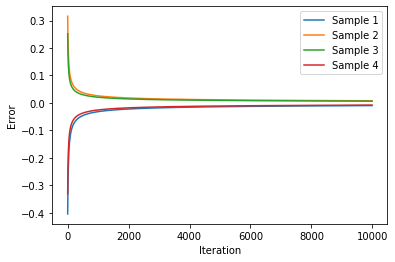

In [10]:
# Plot the error in each sample at each iteration
lines = plt.plot(nstep * np.arange(npts), l1_error.T)
lines[0].axes.set_xlabel('Iteration')
lines[0].axes.set_ylabel('Error')
leg = plt.legend(lines, ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4'])

<a id='err_wt_deriv'></a>
### Error Weighted Derivative
Once the error `l1_error` is determined, it is used to correct the synapse weights `syn0` via the **error weighted derivative**, `l1_error * nonlin(l1, True)`. The plot below shows the sigmoid function $\sigma(x)$ and its derivative at $x$=(-1, 0, 2). Larger values of $|\sigma|$ have a shallower slope while smaller values of $|\sigma|$ have a steeper slope.

When the model is confident in its prediction, i.e. when `|np.dot(l1, syn0)|` is large and $\sigma=$`l1` is close to `0` or `1`, the derivative $d\sigma/dx$ is small and therefore is the correcton to the `syn0` is also small.

In [11]:
print('l1_delta = l1_error * nonlin(l1, True))\n' \
      '  {} =   {} * {}'.format((l1_delta.shape[0], l1_delta.shape[1] // npts),
                                (l1_error.shape[0], l1_error.shape[1] // npts),
                                (l1.shape[0], l1.shape[1] // npts)
                               )
     )

l1_delta = l1_error * nonlin(l1, True))
  (4, 1) =   (4, 1) * (4, 1)


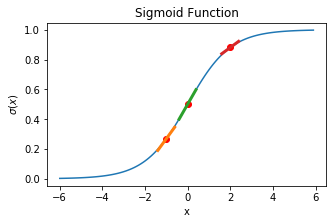

In [12]:
# Plot the sigmoid function again
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(x_sigmoid, y_sigmoid)
ax.set_title('Sigmoid Function')
ax.set_xlabel('x')
ax.set_ylabel('$\sigma(x)$')

# Choose three points
x_pts = np.array([-1, 0, 2])
y_pts = nonlin(x_pts)
ax.plot(x_pts, y_pts, 'ro')

# Plot the derivative at those points
x_delta = 0.4
x_step = 0.01
y_deriv = nonlin_deriv(x_pts)
y_intercept = y_pts - y_deriv*x_pts
for i in range(len(x_pts)):
    x_pts_deriv = np.arange(x_pts[i]-x_delta, x_pts[i]+x_delta, x_step)
    y_pts_deriv = y_deriv[i]*x_pts_deriv + y_intercept[i]
    ax.plot(x_pts_deriv, y_pts_deriv, linewidth=3)

<a id='back_propagation'></a>
### Training: Back Propagation
The model is trained by back-propagating the errors in the output to the synapses in previous layers. In the figures below, we see the weighted sum of inputs `l0 dot syn0` is initially near `0`, and the model indicates that its predictions are uncertain, with `l1`~0.5 and large `l1_error`. Because the slope of $\sigma$ is large at $\sigma(0.5)$, the `l1_error` values are weighted heavily and the correction term `l1_delta` is also large. This information is **back-propagated** to `syn0`, providing training to the model.

As a result, the `syn0` weights grow, the weighted sums increase, and `l1` converges toward the answer.

In [13]:
print('  syn0 +=   l0.T dot l1_delta\n' \
      '{} += {} dot {}'.format((syn0.shape[0], syn0.shape[1] // npts),
                                l0.T.shape,
                                (l1_delta.shape[0], l1_delta.shape[1] // npts)
                               )
     )

  syn0 +=   l0.T dot l1_delta
(3, 1) += (3, 4) dot (4, 1)


Text(0, 0.5, 'Syn0')

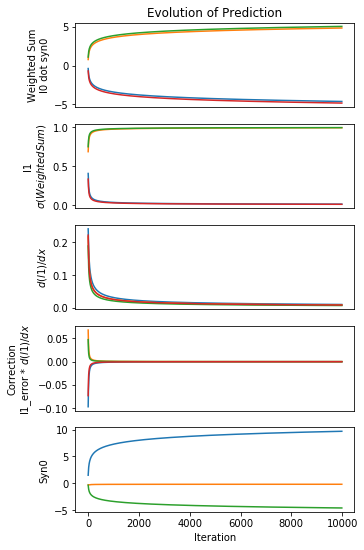

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5, 9))

axes[0].plot(nstep * np.arange(npts), weighted_sum.T)
axes[0].set_title('Evolution of Prediction')
axes[0].set_xticks([])
axes[0].set_ylabel('Weighted Sum\nl0 dot syn0')

axes[1].plot(nstep * np.arange(npts), l1.T)
axes[1].set_xticks([])
axes[1].set_ylabel('l1\n$\sigma(Weighted Sum)$')

axes[2].plot(nstep * np.arange(npts), l1_deriv.T)
axes[2].set_xticks([])
axes[2].set_ylabel('$d(l1)/dx$')

axes[3].plot(nstep * np.arange(npts), l1_delta.T)
axes[3].set_xticks([])
axes[3].set_ylabel('Correction\nl1_error * $d(l1)/dx$')

axes[4].plot(nstep * np.arange(npts), syn0.T)
axes[4].set_xlabel('Iteration')
axes[4].set_ylabel('Syn0')